# Divertor spectroscopy on steroids (density only)

Due to its versatility, the lines of sight for divertor spectroscopy can change from shot to shot. 

So, for your convenience, I went ahead and spent my non-precious time putting together this notebook that does everything for you. You only need to provide a shot number, and the notebook will show you all the lines of sight and their respective average densities. You're welcome!

Since most of the data will be useless, you can use the second half of the notebook to refine your search for eternal lif... I mean... whatever it is you are searching for. 

In [7]:
%matplotlib notebook

from ipfnpytools.spec_channels import spec_channels
from ipfnpytools.getsig import getsig
from ipfnpytools.get_los_diaggeom import get_los
from ipfnpytools.getVessel import getVessel
from ipfnpytools.plotVessel import plotVessel
from ipfnpytools.current_flattop import current_flattop
from ipfnpytools.closest import closest
import matplotlib.pyplot as plt
import map_equ
import dd
import datetime as dt
import divertor as div
import re
from scipy.signal import medfilt
import numpy as np
# plt.style.use('./Styles/darklab.mplstyle')
from spectroscopy import get_sbd as get_reckt
from spectroscopy import get_spec_channels_and_los, best_column_number
import reflectometry as rfl
from equilibrium import plot_equilibrium

### <span style="color:blue">Parameters: Data Fetching</span>

In [58]:
# Choose the shot number
shot = 29864

# Search for SBD data withing the following shotfiles ['EVL', 'FVL', 'GVL', 'HVL']
# Choose which shotfiles to include in you search
shotfiles = [
    'EVL',
    'FVL', 
    'GVL', 
    'HVL'
]
   
# -------------- Do not touch from here unless you are a PRO ----------------------
    
channels, los = get_spec_channels_and_los(shot, shotfiles)
vessel = getVessel(shot)

[t0, t1] = current_flattop(shot)

EVS shotfile OK
FVS shotfile OK
GVS shotfile NOT FOUND
HVS shotfile NOT FOUND
Shot 29864 took place on 27Mar2013;12:33:39
Using the LOS stored in file /afs/ipp/u/sprd/loscoord/LOS_COORD_2013
Shot: 29864
EVL shotfile does not exist
FVL shotfile does not exist
GVL shotfile does not exist
HVL shotfile does not exist


### <span style="color:blue">Parameters: Post Processing</span>

In [35]:
# Choose the number of points to apply a median filter
median_points = 31

### <span style="color:blue">Parameters: Data Visualization</span>

In [36]:
# Choose the number of columns to display the SBD data. If None, I'll try to guess :)
cols = None

# -------------- Do not touch from here unless you are a PRO ------------------------

linegroups = []
for sf in shotfiles:
    try:
        for prefix in list(set(list(map(lambda x: x[0:3], channels[sf])))):
            linegroups.append(sf + '-' + prefix)
    except KeyError:
        pass
    
_, cols = best_column_number(len(linegroups)) if cols is None else (None, cols)
rows = int(len(linegroups)/cols) + (len(linegroups) % cols != 0) 

## Plot all lines of sight

<IPython.core.display.Javascript object>


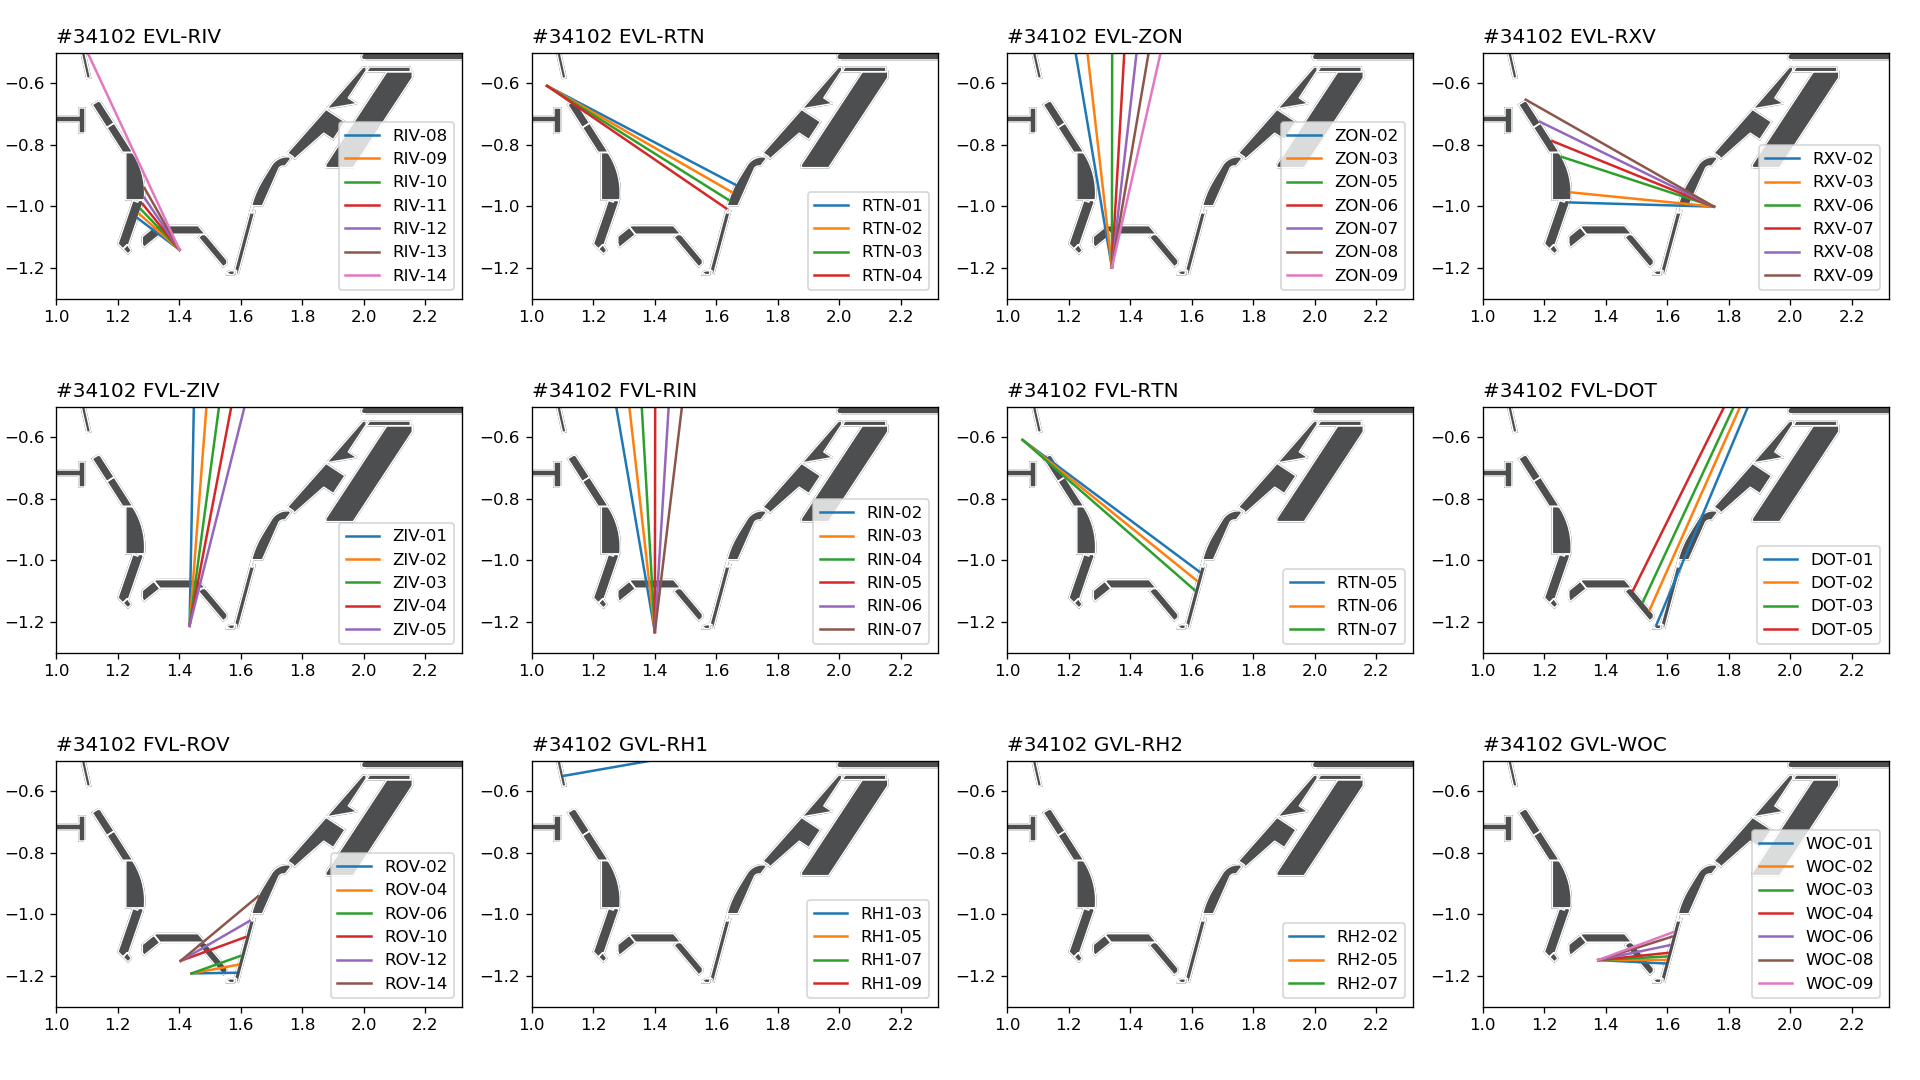

In [37]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 9), dpi=120)

plt.tight_layout()

for group, ax in zip (linegroups, axes.flatten()):
    plot_channels = list(filter(lambda x: x[0:3] == group[-3:], channels[group[:3]]))
    plot_channels.sort()
    plotVessel(vessel, ax, color_border='w', color_structure='#4D4E4F', lw_border=0.9)
    for chan in plot_channels:
        try:
            ax.plot(los[chan]['R'], los[chan]['Z'], label=chan)
        except KeyError as e:
            print("NOT FOUND: Coordinates for LOS", e)
    ax.legend(loc='lower right')
        
    ax.set_aspect('equal')
#     ax.set_ylabel('Z [m]')
#     ax.set_xlabel('R [m]')
    ax.set_title('#' + str(shot) + ' ' + group, loc='left')
    ax.set_xlim(1.0, 2.32)
    ax.set_ylim(-1.3, -0.5)

try:
    for ax in axes.flatten()[len(linegroups):]:
        ax.remove()
except IndexError:
    pass
    
# plotVessel(vessel, ax, color_border='w', color_structure='#4D4E4F', lw_border=0.9)

# for chan in plot_channels:
# #     print(los[chan]['R'], los[chan]['Z'])
#     ax.plot(los[chan]['R'], los[chan]['Z'], color='C2')

# ax.set_aspect('equal')
# ax.set_ylabel('Z [m]')
# ax.set_xlabel('R [m]')
# ax.set_title('#'+str(shot), loc='left')
# ax.set_xlim(1.0, 2.32)
# ax.set_ylim(-1.3, -0.5)
# plt.show()


## Plot all signals

<IPython.core.display.Javascript object>


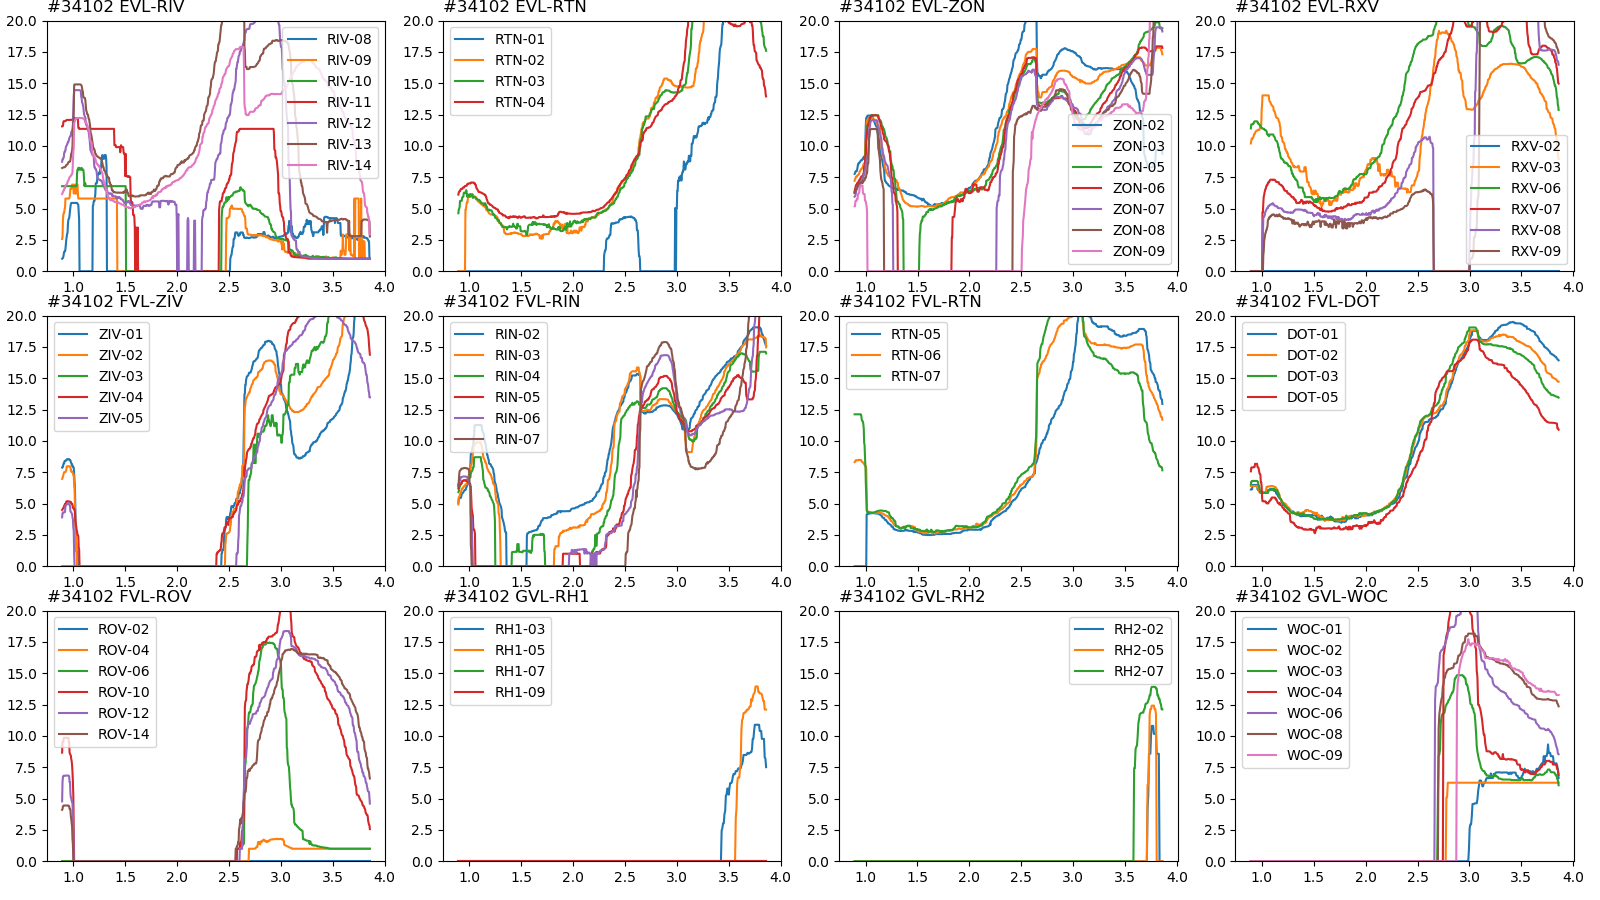

In [38]:
fig1, axes1 = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 9))

plt.tight_layout()

for group, ax in zip (linegroups, axes1.flatten()):
    plot_channels = list(filter(lambda x: x[0:3] == group[-3:], channels[group[:3]]))
    plot_channels.sort()
    for chan in plot_channels:
        time, ne = get_reckt(shot, chan)
        ne = ne[(time > t0) & (time < t1)]
        time = time[(time > t0) & (time < t1)]
        ax.plot(time, medfilt(ne, median_points)*1e-19, label=chan)
    ax.legend(loc='best')
    ax.set_title('#' + str(shot) + ' ' + group, loc='left')
    ax.set_ylim(0, 20)


try:
    for ax in axes1.flatten()[len(linegroups):]:
        ax.remove()
except IndexError:
    pass

## Plot all signals in a color map

In [ ]:
fig2, axes2 = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 9))
plt.tight_layout()
plt.subplots_adjust(
left = 0.05, # the left side of the subplots of the figure
right = 0.9,  # the right side of the subplots of the figure
bottom = 0.1, # the bottom of the subplots of the figure
top = 0.9,    # the top of the subplots of the figure
wspace = 0.35, # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.2, # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
)

for group, ax in zip (linegroups, axes2.flatten()):
    plot_channels = list(filter(lambda x: x[0:3] == group[-3:], channels[group[:3]]))
    plot_channels.sort()
    ne_list = []
    for chan in plot_channels:
        time, ne = get_reckt(shot, chan)
        ne = ne[(time > t0) & (time < t1)]
        time = time[(time > t0) & (time < t1)]
        ne_list.append(medfilt(ne, median_points)*1e-19)
    ne_list = np.array(ne_list)
    im = ax.imshow(ne_list, aspect='auto', extent=(t0, t1, 0, 1), interpolation='gaussian', origin='lower')
    plt.sca(ax)
    cbar = plt.colorbar(im)
#     cbar.set_label('n$_e$ [10$^{19}$ m$^{-3}$]', rotation=270, labelpad=20)
    plt.yticks((np.arange(len(plot_channels))+0.5)/len(plot_channels), plot_channels)
    for i, ytick in enumerate(ax.get_yticklabels()):
        ytick.set_color("C" + str(i))
    
#     ax.legend(loc='best')
    ax.set_title('#' + str(shot) + ' ' + group, loc='left')


try:
    for ax in axes2.flatten()[len(linegroups):]:
        ax.remove()
except IndexError:
    pass

# # Set a color dictionary
# colors = {'RIV':'C0', 'ZIV':'C0', 'RIN':'C1', 'ZON':'C2', 'ROV':'C3'}

# # Draw the vessel on a secondary plot
# if (equilibrium is not None) or (los_filepath is not None):
#     fig2, axes2 = plt.subplots(1, 2, figsize = (9, 3))
#     plt.subplots_adjust(wspace=0.05)
#     plt.sca(axes2[0])
#     plotVessel(vessel, axes2[1], color_border='w', color_structure='#4D4E4F', lw_border=0.9)
#     axes2[1].set_aspect('equal')
#     axes2[1].set_ylabel('Z [m]')
#     axes2[1].set_xlabel('R [m]')
#     axes2[1].set_xlim(1.0, 2.0)
#     axes2[1].set_ylim(-1.3, -0.5)

# else: 
#     fig2 = plt.figure(figsize = (6, 3))
#     ax = plt.subplot(111)
    
# im = plt.imshow(interp_ne, aspect='auto', extent=(0, 10, 0, 1), vmax=None, interpolation='gaussian')
# cbar = plt.colorbar()
# cbar.set_label('n$_e$ [10$^{19}$ m$^{-3}$]', rotation=270, labelpad=20)
# plt.yticks((np.arange(len(channels))+0.5)/len(channels), channels[::-1])
# for ytick in plt.gca().get_yticklabels():
#     ytick.set_color(colors[ytick.get_text()[0:3]])
# plt.text(2.5, 0.05, "HFS", color='white', fontsize='24')
# plt.text(2.5, 0.85, "LFS", color='white', fontsize='24')
# plt.xlabel("Time [s]")
# plt.tight_layout()
# plt.suptitle(str(shot))

# # Draw LOS
# if los_filepath is not None:    
#     for chan in channels:
#         axes2[1].plot(evl_los['signals'][chan]['0']['R'], evl_los['signals'][chan]['0']['z'], color=colors[chan[0:3]], lw=1)

# # Plotting the magnetic equilibrium
# if equilibrium is not None:
#     cs = axes2[1].contour(eq.Rmesh, eq.Zmesh, np.sqrt((eq.pfm[:,:,:] - eq.psi0)/(eq.psix-eq.psi0))[:,:,index].T,
#                           levels=contourlevels, linewidths=1.2, cmap='viridis_r')



# plt.tight_layout()

## Second half of this amazing notebook

Now that you've seen all the available SBD data, you can start refining your search. Choose just a few lines of sight and plot them.

In [ ]:
chosen_ones = [
    'RH2-01',
    'RH2-02',
    'RH2-03',
]

In [ ]:
fig3, axes3 = plt.subplots(figsize=(7, 3))
for channel in chosen_ones:
    time, ne = get_reckt(shot, channel)
    plt.plot(time, medfilt(ne, median_points)*1e-19, label=channel)
plt.xlabel("Time [s]")
plt.ylabel("n$_e$ [10$^{19}$ m$^{-3}$]")
plt.grid()
plt.legend()
plt.xlim((t0, t1))
plt.ylim((0, 50))
plt.tight_layout()
rfl.autoscale(axes3, margin=0.2)
fig3.tight_layout()

### <span style="color:blue">Parameters: Data Visualization</span>

In [ ]:
# The lines of sight side-by-side with a countout plot of the signals
show_los = True

# Choose between 'EQH' and 'IDE'. Choose None to prevent plotting
equilibrium = 'EQH'

For some genius reason, the time axis of the different shotfiles EVL, FVL, etc... do not match -.-'

So we do an interpolation

In [ ]:
time_list = []
ne_list = []
for channel in chosen_ones:
    time, ne = get_reckt(shot, channel)
    ne = medfilt(ne, median_points)*1e-19
    time_list.append(time)
    ne_list.append(ne)
    
# interp_times = np.linspace(0, 10, 2000)
interp_times = time_list[0]

interp_ne = []
for t, ne in zip(time_list, ne_list):
    interp_ne.append(np.interp(interp_times, t, ne, left=0, right=0))
interp_ne = np.array(interp_ne)

In [ ]:
# Draw the vessel on a secondary plot
if (equilibrium is not None) or show_los:
    fig2, axes2 = plt.subplots(1, 2, figsize = (9, 3))
    plt.subplots_adjust(wspace=0.05)
    plt.sca(axes2[0])
    plotVessel(vessel, axes2[1], color_border='w', color_structure='#4D4E4F', lw_border=0.9)
    axes2[1].set_aspect('equal')
    axes2[1].set_ylabel('Z [m]')
    axes2[1].set_xlabel('R [m]')
    axes2[1].set_xlim(1.0, 2.0)
    axes2[1].set_ylim(-1.3, -0.5)

else: 
    fig2 = plt.figure(figsize = (6, 3))
    ax = plt.subplot(111)
    
im = plt.imshow(interp_ne, aspect='auto', extent=(0, 10, 0, 1), vmax=None, interpolation='gaussian')
cbar = plt.colorbar()
cbar.set_label('n$_e$ [10$^{19}$ m$^{-3}$]', rotation=270, labelpad=20)
plt.yticks((np.arange(len(chosen_ones))+0.5)/len(chosen_ones), chosen_ones[::-1])
for i, ytick in enumerate(plt.gca().get_yticklabels()):
    ytick.set_color("C%d"%i)
# plt.text(2.5, 0.05, "HFS", color='white', fontsize='24')
# plt.text(2.5, 0.85, "LFS", color='white', fontsize='24')
plt.xlabel("Time [s]")
plt.tight_layout()
plt.suptitle(str(shot))
plt.xlim((t0, t1))

# Draw LOS
if show_los:    
    for i, chan in enumerate(chosen_ones[::-1]):
        axes2[1].plot(los[chan]['R'], los[chan]['Z'], color='C%d'%i, lw=1)

# Plotting the magnetic equilibrium
if equilibrium is not None:
    equil = plot_equilibrium(shot, 3, equilibrium, axes2[1])    

plt.tight_layout();